In [3]:
from joblib import Parallel, delayed
from datetime import datetime
from tqdm import tqdm
from Bio import SeqIO
from Bio.Seq import Seq
import re
from collections import Counter
import gzip
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import os
import pandas as pd
from multiprocessing import Pool
import subprocess
import glob
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from tqdm.auto import tqdm
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper


class PairedFastq():
    def __init__(self, path, for_reads, rew_reads):
        """Initialize the PairedFastq class with the provided file names and path."""
        self.for_reads = for_reads
        self.rew_reads = rew_reads
        self.path = path
    
    @timeit
    def split_fastq_files(self, out_folder, cores):
        
        def test_even(infolder):
            nOfFile = len(os.listdir(infolder))
            if nOfFile % 2 == 0:
                print("Even files in path")
            else:
                print("error in numbers of files")

        cmd = "seqkit split2 -p {cores} -1 {file1} -2 {file2} -O {out_dir} -f"
        cmd = cmd.format(
            cores=cores,
            file1=os.path.join(self.path,self.for_reads),
            file2=os.path.join(self.path,self.rew_reads),
            out_dir = out_folder)
        
        result = subprocess.run(cmd, shell=True, text=True, capture_output=True)

        if result.returncode == 0:
            print("Command executed successfully.")
        else:
            print(f"An error occurred (return code: {result.returncode}).")
            print("Error output:", result.stderr)
            
        test_even(out_folder)
        
    @staticmethod
    def pair_seqkit_fastq_files(in_folder):
        pattern = os.path.join(in_folder, "*_1.part*")
        files_1 = glob.glob(pattern)
        pattern = os.path.join(in_folder, "*_2.part*")
        files_2 = glob.glob(pattern)
        return files_1,files_2
    
    @staticmethod
    def process_fastq_files(fastq_1s, fastq_2s, num_threads, func,  *args, **kwargs):
        with ProcessPoolExecutor(max_workers=num_threads) as executor:
            futures = []
            for fastq_1, fastq_2 in zip(fastq_1s, fastq_2s):
                #bam_output_prefix = os.path.join(output_prefix, os.path.splitext(os.path.basename(bamfile))[0])
                future = executor.submit(func, fastq_1, fastq_2, *args, **kwargs)
                futures.append(future)

            results = [future.result() for future in futures]

        return results      

In [4]:
def find_codon(read_1, read_2, oligo): 
    '''
    Return each time an oligo is found in forward or reverse;
    We dont want to count the codon two times because 
    is present in forward and reverse reads.
    '''

    #look for forward sequence
    #return if found
    #look for the reverse-complement sequence
    revc_oligo = str(Seq(oligo).reverse_complement())
    
    if oligo in read_1+' | '+read_2:
        return 1
    
    elif revc_oligo in read_1+' | '+read_2:
        return 1

    else:
        return 0
    

def make_counts(fastq_1, fastq_2, oligo):
    file_1 = FastqGeneralIterator(gzip.open(fastq_1, "rt"))
    file_2 = FastqGeneralIterator(gzip.open(fastq_2, "rt")) 
    head1, tail1 = os.path.split(fastq_1)
    head2, tail2 = os.path.split(fastq_2)
    print('start', tail1, tail2)
    out = sum([find_codon(read_1[1], read_2[1], oligo) for read_1, read_2 in zip(file_1, file_2)])
    return out

In [24]:
import shutil

def pipline_fastq(
    experiment_name='',
    fastq_file_1 = '',
    fastq_file_2 = '',
    oligos = [],
    output_folder = '',
    output_name = '',
    cores = '',
    make_reverse_complement = False):
    
    working_path = os.environ.get("TMPDIR")
    os.makedirs(os.path.join(working_path, experiment_name), exist_ok=True)
    
    print('copying files:')
    source_file = os.path.join(experiment_name, fastq_file_1)
    destination_file_1 = os.path.join(working_path, experiment_name, fastq_file_1)
    if os.path.exists(destination_file_1):
        print('file', destination_file_1, 'exsist')
        pass
    else:
        print(destination_file_1)
        shutil.copy(source_file, destination_file_1)

    source_file = os.path.join(experiment_name, fastq_file_2)
    destination_file_2 = os.path.join(working_path, experiment_name, fastq_file_2)
    if os.path.exists(destination_file_2):
        print('file', destination_file_2, 'exsist')
        pass
    else:
        print(destination_file_2)
        shutil.copy(source_file, destination_file_2)   
    
    
    pf = PairedFastq(
        os.path.join(working_path, experiment_name), 
        fastq_file_1, 
        fastq_file_2
    )
    
    print('splitting fastq files')
    pf.split_fastq_files(
        os.path.join(working_path,'split_files'),
        cores=cores
    )
    
    files = PairedFastq.pair_seqkit_fastq_files(os.path.join(working_path,'split_files'))
    
    if make_reverse_complement:
        oligos = [str(Seq(oligo).reverse_complement()) for oligo in oligos]
    
    print('counting fastq files')
    
    output = open(os.path.join(output_folder, output_name),'w')
    for oligo_index, oligo in enumerate(oligos):
        out =  PairedFastq.process_fastq_files(files[0], files[1], cores, make_counts, oligo)
        print('processed oligo', oligo_index+1, oligo, sum(out))
        output.write('\t'.join([str(oligo_index+1), oligo, str(sum(out))])+'\n')
        output.flush()
    output.close()    

In [25]:
folders_to_process = {}
for folder in os.listdir(os.curdir):
    if folder.startswith('Ld'):
        for fastq_file in os.listdir(folder):
            if fastq_file.endswith('_1.fq.gz'):
                f1=fastq_file
            if fastq_file.endswith('_2.fq.gz'):
                f2=fastq_file
        folders_to_process[folder]=[f1,f2]
        
print('len(folders_to_process)',len(folders_to_process))

oligos = [
'TAGCATCAGATAGTGCTGAGTAG',
'TAGTATGGCGTAGCGCAATATAG',
'TAGGCTTCCATAGATCCTTGTAG',
'TAGAGTGGCTTAGGACAATCTAG',
'TAGTTCGCGTTAGCCTATACTAG',
'TAGGTTCTGGTAGACCTCAATAG',
'TAGAGAAGAATAGGAGGAGGTAG',
'TAGGATCGACTAGAGCTAGTTAG',
'TAGCGCAATCTAGTATGGCTTAG',
'TAGCAACCATTAGTGGTTGCTAG',
'TAGTCGCTCGTAGCTATCTATAG',
'TAGCCTACACTAGTTCGTGTTAG',
'TAGGCAAGAGTAGATGGAGATAG',
'TAGAGACAACTAGGAGTGGTTAG',
'TAGTGCACTCTAGCATGTCTTAG',
'TAGCTCCTACTAGTCTTCGTTAG',
'TAGATGGAATTAGGCAAGGCTAG',
'TAGGCGTGGATAGATACAAGTAG',
'TAGCACAGCTTAGTGTGATCTAG',
'TAGATAACTGTAGGCGGTCATAG',
'TAGTGGTCGATAGCAACTAGTAG',
'TAGAGAATAGTAGGAGGCGATAG',
'TAGCTCAGTATAGTCTGACGTAG',
'TAGTATCAGTTAGCGCTGACTAG',
'TAGAGCAACATAGGATGGTGTAG',
'TAGTGTAGCGTAGCACGATATAG',
'TAGCAGAACATAGTGAGGTGTAG',
'TAGACCAAGATAGGTTGGAGTAG',
'TAGGCAATCGTAGATGGCTATAG',
'TAGCAACAGCTAGTGGTGATTAG',
'TCACCACCCTCAACCACCCCTCA',
'GCAGAGGAAGAGGAAGGCGAT',
    ]
print('len(oligos)',len(oligos))

len(folders_to_process) 32
len(oligos) 32


In [20]:
#rm  $TMPDIR/split_files/*
#!rm  -r $TMPDIR/split_files/LdBAR31PMM

In [27]:
scratch_path = '/tmp/1144591.1.4week.q/'
for folder in folders_to_process:
    f1 = folders_to_process[folder][0]
    f2 = folders_to_process[folder][1]
    print('processing', folder)
    
    pipline_fastq(
        experiment_name=folder,
        fastq_file_1 = f1,
        fastq_file_2 = f2,
        oligos = oligos,
        output_folder = 'out',
        output_name = 'count_'+folder+'.tsv',
        cores = 6,
        make_reverse_complement = False)    
    
    shutil.rmtree(os.path.join(scratch_path,folder))
    shutil.rmtree(os.path.join(scratch_path,'split_files'))
    print('--------')


processing LdBAR31PMM
copying files:
/tmp/1144591.1.4week.q/LdBAR31PMM/V350160606_L01_B5GANIxmouRAATA-60_1.fq.gz
/tmp/1144591.1.4week.q/LdBAR31PMM/V350160606_L01_B5GANIxmouRAATA-60_2.fq.gz
splitting fastq files
Command executed successfully.
Even files in path
Function split_fastq_files(<__main__.PairedFastq object at 0x2b8ac6c4e860>, '/tmp/1144591.1.4week.q/split_files') {'cores': 6} Took 46.6521 seconds
counting fastq files
start V350160606_L01_B5GANIxmouRAATA-60_1.part_001.fq.gz V350160606_L01_B5GANIxmouRAATA-60_2.part_001.fq.gz
start V350160606_L01_B5GANIxmouRAATA-60_1.part_002.fq.gz V350160606_L01_B5GANIxmouRAATA-60_2.part_002.fq.gz
start V350160606_L01_B5GANIxmouRAATA-60_1.part_003.fq.gz V350160606_L01_B5GANIxmouRAATA-60_2.part_003.fq.gz
start V350160606_L01_B5GANIxmouRAATA-60_1.part_005.fq.gz V350160606_L01_B5GANIxmouRAATA-60_2.part_005.fq.gz
start V350160606_L01_B5GANIxmouRAATA-60_1.part_004.fq.gz V350160606_L01_B5GANIxmouRAATA-60_2.part_004.fq.gz
start V350160606_L01_B5GANIxmo

In [54]:
merge = []
for file_name in os.listdir('out'):
    if 'count_' in file_name:
        temp = pd.read_csv('out/'+file_name,sep='\t',index_col=[0],header=None)
        temp.columns = ['barcode',file_name.split('_')[1].split('.')[0]]
        merge.append(temp.iloc[:,-1])

merge.append(temp['barcode'])
merge = pd.concat(merge,axis=1)

In [55]:
merge = merge.reset_index()
merge.columns = ['barcode_id']+list(merge.columns)[1:]
merge.head()

,barcode_id,LdBAR31PMM,LdBar04-6148,LdBar02-0690,LdBAR38PMM,LdBAR33PMM,LdBar03-0690,LdBar08-LXE,LdBar21-BA05,LdBAR42PMM,...,LdBAR35PMM,LdBar10-899A,LdBAR32PMM,LdBar01-NI,LdBAR40PMM,LdBar11-899A,LdBar06-245A,LdBar15-AmB,LdBAR37PMM,barcode
0,1,40532,2409,28364,22920,26757,1440,301,178,13522,...,14746,915,37786,37902,9792,205,1083,316,16003,TAGCATCAGATAGTGCTGAGTAG
1,2,74403,2141,15407,9489,84482,881,483964,764,28844,...,35466,1425,54836,42760,1108,848,389916,959,34569,TAGTATGGCGTAGCGCAATATAG
2,3,12844,1687,6456,2722,16723,2359,10125,625904,5370,...,13743,226201,8068,4167,977,569439,23359,686,12679,TAGGCTTCCATAGATCCTTGTAG
3,4,445,22,279,54,504,30,7,10,84,...,351,31,775,346,11,10,14,19145,327,TAGAGTGGCTTAGGACAATCTAG
4,5,6872,1010,4837,297701,17851,1001,850,718,33326,...,28586,883,6395,7061,522269,750,761,519150,66688,TAGTTCGCGTTAGCCTATACTAG


In [57]:
merge = merge[['barcode_id', 'barcode','LdBAR31PMM', 'LdBar04-6148', 'LdBar02-0690',
       'LdBAR38PMM', 'LdBAR33PMM', 'LdBar03-0690', 'LdBar08-LXE',
       'LdBar21-BA05', 'LdBAR42PMM', 'LdBar00-Start', 'LdBar16-SbIII',
       'LdBar09-LXE', 'LdBar07-245A', 'LdBar14-AmB', 'LdBar12-6174',
       'LdBar20-BA05', 'LdBAR39PMM', 'LdBAR34PMM', 'LdBAR41PMM', 'LdBAR36PMM',
       'LdBar13-6174', 'LdBar05-6148', 'LdBAR43PMM', 'LdBAR35PMM',
       'LdBar10-899A', 'LdBAR32PMM', 'LdBar01-NI', 'LdBAR40PMM',
       'LdBar11-899A', 'LdBar06-245A', 'LdBar15-AmB', 'LdBAR37PMM' ]]
merge.head()

,barcode_id,barcode,LdBAR31PMM,LdBar04-6148,LdBar02-0690,LdBAR38PMM,LdBAR33PMM,LdBar03-0690,LdBar08-LXE,LdBar21-BA05,...,LdBAR43PMM,LdBAR35PMM,LdBar10-899A,LdBAR32PMM,LdBar01-NI,LdBAR40PMM,LdBar11-899A,LdBar06-245A,LdBar15-AmB,LdBAR37PMM
0,1,TAGCATCAGATAGTGCTGAGTAG,40532,2409,28364,22920,26757,1440,301,178,...,7719,14746,915,37786,37902,9792,205,1083,316,16003
1,2,TAGTATGGCGTAGCGCAATATAG,74403,2141,15407,9489,84482,881,483964,764,...,51233,35466,1425,54836,42760,1108,848,389916,959,34569
2,3,TAGGCTTCCATAGATCCTTGTAG,12844,1687,6456,2722,16723,2359,10125,625904,...,4247,13743,226201,8068,4167,977,569439,23359,686,12679
3,4,TAGAGTGGCTTAGGACAATCTAG,445,22,279,54,504,30,7,10,...,12,351,31,775,346,11,10,14,19145,327
4,5,TAGTTCGCGTTAGCCTATACTAG,6872,1010,4837,297701,17851,1001,850,718,...,8970,28586,883,6395,7061,522269,750,761,519150,66688


In [58]:
merge.to_csv('combine.csv',index=False)

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

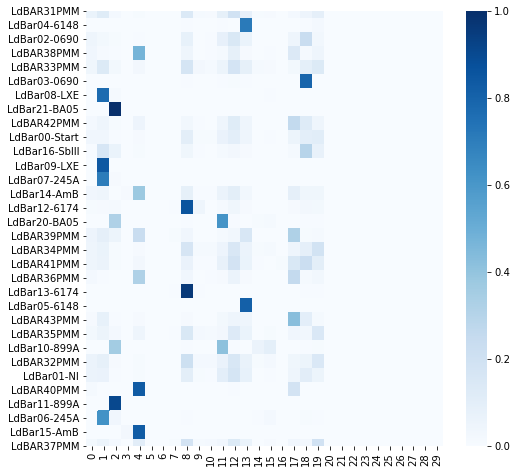

In [78]:
fig,ax=plt.subplots(figsize=(8,8))
cols = ['LdBAR31PMM', 'LdBar04-6148', 'LdBar02-0690',
       'LdBAR38PMM', 'LdBAR33PMM', 'LdBar03-0690', 'LdBar08-LXE',
       'LdBar21-BA05', 'LdBAR42PMM', 'LdBar00-Start', 'LdBar16-SbIII',
       'LdBar09-LXE', 'LdBar07-245A', 'LdBar14-AmB', 'LdBar12-6174',
       'LdBar20-BA05', 'LdBAR39PMM', 'LdBAR34PMM', 'LdBAR41PMM', 'LdBAR36PMM',
       'LdBar13-6174', 'LdBar05-6148', 'LdBAR43PMM', 'LdBAR35PMM',
       'LdBar10-899A', 'LdBAR32PMM', 'LdBar01-NI', 'LdBAR40PMM',
       'LdBar11-899A', 'LdBar06-245A', 'LdBar15-AmB', 'LdBAR37PMM' ]
sns.heatmap((merge.iloc[:-2][cols]/merge.iloc[:-2][cols].max().max()).T,
            cmap='Blues',ax=ax)

In [74]:
merge.head()

,barcode_id,barcode,LdBAR31PMM,LdBar04-6148,LdBar02-0690,LdBAR38PMM,LdBAR33PMM,LdBar03-0690,LdBar08-LXE,LdBar21-BA05,...,LdBAR43PMM,LdBAR35PMM,LdBar10-899A,LdBAR32PMM,LdBar01-NI,LdBAR40PMM,LdBar11-899A,LdBar06-245A,LdBar15-AmB,LdBAR37PMM
0,1,TAGCATCAGATAGTGCTGAGTAG,40532,2409,28364,22920,26757,1440,301,178,...,7719,14746,915,37786,37902,9792,205,1083,316,16003
1,2,TAGTATGGCGTAGCGCAATATAG,74403,2141,15407,9489,84482,881,483964,764,...,51233,35466,1425,54836,42760,1108,848,389916,959,34569
2,3,TAGGCTTCCATAGATCCTTGTAG,12844,1687,6456,2722,16723,2359,10125,625904,...,4247,13743,226201,8068,4167,977,569439,23359,686,12679
3,4,TAGAGTGGCTTAGGACAATCTAG,445,22,279,54,504,30,7,10,...,12,351,31,775,346,11,10,14,19145,327
4,5,TAGTTCGCGTTAGCCTATACTAG,6872,1010,4837,297701,17851,1001,850,718,...,8970,28586,883,6395,7061,522269,750,761,519150,66688
